In [13]:
%load_ext autoreload
%autoreload 2

import pdb
import pickle, os
import numpy as np
import cvxpy as cp
import concurrent.futures

import matplotlib.pyplot as plt
%matplotlib inline

from free_flyer import FreeFlyer
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Problem parameters

In [14]:
n = 2; m = 2

N = 6 # horizon
dh = 0.75
Ak = np.eye(2*n)
Ak[:n,n:] = dh*np.eye(n)
Bk = np.zeros((2*n,m))
Bk[:n,:] = 0.5*dh**2 * np.eye(n)
Bk[n:,:] = dh*np.eye(n)

Q = np.diag([2,2,1,1.])
R = 1000.*np.eye(m)

mass_ff_min = 15.36
mass_ff_max = 18.08
mass_ff = 0.5*(mass_ff_min+mass_ff_max)
thrust_max = 2*1.  # max thrust [N] from two thrusters 
umin = -thrust_max/mass_ff
umax = thrust_max/mass_ff
velmin = -0.2
velmax = 0.2
posmin = np.zeros(n)

ft2m = 0.3048
posmax = ft2m*np.array([12.,9.])
max_box_size = 0.75
min_box_size = 0.25
box_buffer = 0.025
border_size = 0.05

n_obs = 8

prob_params = [N, Ak, Bk, Q, R, n_obs , \
    posmin, posmax, velmin, velmax, umin, umax]

### Randomly sample obstacles and then find free x0

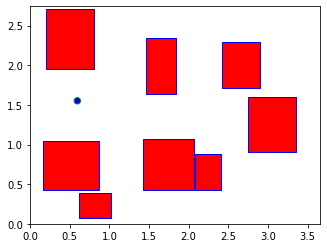

<Figure size 432x288 with 0 Axes>

In [15]:
obstacles = random_obs(n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size)
x0 = findIC(obstacles, posmin, posmax, velmin, velmax)

plt.axes()
for obstacle in obstacles:
    rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                              obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                             fc='red', ec='blue')
    plt.gca().add_patch(rectangle)
    plt.axis('scaled')

if x0.size > 0:
    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
plt.gca().add_patch(circle)    

ax = plt.gca()
ax.margins(0)
ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
fig = plt.figure()
plt.show()

### Or sample x0 and place obstacles along the way to xg

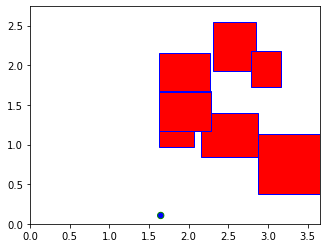

In [17]:
x0 = np.hstack((posmin + 0.5*(posmax-posmin)*np.random.rand(2), \
               velmin + (velmax-velmin)*np.random.rand(2)))
obstacles = find_obs(x0, n_obs, posmin, posmax, \
                border_size, box_buffer, min_box_size, max_box_size, \
                ignore_intersection=False)
if len(obstacles) == 0:
    obstacles = find_obs(x0, n_obs, posmin, posmax, \
                    border_size, box_buffer, min_box_size, max_box_size, \
                    ignore_intersection=True)

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
    plt.gca().add_patch(circle)    

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

### For obstacle map feature, shade in one particular obstacle

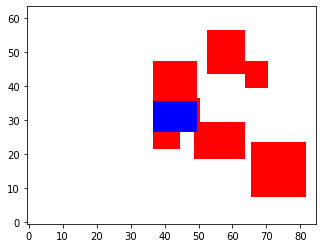

In [18]:
obs_ii = 7

W_H_ratio = posmax[0] / posmax[1]
H = 64
W = int(W_H_ratio * H)

table_img = np.ones((H,W,3))

obs_ll = [ii for ii in range(n_obs) if ii is not obs_ii]
obs_ll.append(obs_ii)
obs_ll
for ll in obs_ll:
    obs = obstacles[ll]
    row_range = range(int(float(obs[2])/posmax[1]*H), int(float(obs[3])/posmax[1]*H))
    col_range = range(int(float(obs[0])/posmax[0]*W), int(float(obs[1])/posmax[0]*W))
    row_range = range(np.maximum(row_range[0],0), np.minimum(row_range[-1],H))
    col_range = range(np.maximum(col_range[0],0), np.minimum(col_range[-1],W))

    if ll is obs_ii:
        table_img[row_range[0]:row_range[-1], col_range[0]:col_range[-1], :] = 1
        table_img[row_range[0]:row_range[-1], col_range[0]:col_range[-1], :2] = 0
    else:
        table_img[row_range[0]:row_range[-1], col_range[0]:col_range[-1], 1:] = 0

plt.imshow(table_img)
plt.gca().invert_yaxis()

# Setup pickle file for default parameters

In [20]:
#setup filenames
relative_path = os.getcwd()
dataset_name = 'cc'

if not os.path.isdir(os.path.join(relative_path, 'data', dataset_name)):
    os.mkdir(os.path.join(relative_path+'/data/'+dataset_name))
    
if not os.path.isdir(os.path.join(relative_path, 'config')):
    os.mkdir(os.path.join(relative_path, 'config'))

train_fn = os.path.join(relative_path, 'data', dataset_name, 'train.p')
test_fn = os.path.join(relative_path, 'data', dataset_name, 'test.p')

#load default parameter values
n = 2; m = 2

#define all possible params that can be varied
all_params = ['N', 'Ak', 'Bk', 'Q', 'R', 'n_obs', \
    'posmin', 'posmax', 'velmin', 'velmax', \
    'umin', 'umax', \
    'x0', 'xg', 'obstacles']

## TODO(pculbertson): implement custom param variation.
#plan: split all_params into static & sampled params
#in Problem object, keep param dict with keys == all_params
#on constructing problem, make every param key map to either static value
#or a cvxpy.Parameter object.

### VARY ANY DESIRED PARAM VALUES HERE ###

param_dict = {'N':N, 'Ak':Ak, 'Bk':Bk, 'Q':Q, 'R':R, 'n_obs':n_obs, \
    'posmin':posmin, 'posmax':posmax, 'velmin':velmin, 'velmax':velmax, \
    'umin':umin, 'umax':umax}

#specify which parameters to sample, & their distributions
sampled_params = ['x0', 'xg', 'obstacles']
sample_dists = {'x0': lambda: np.hstack((posmin + (posmax-posmin)*np.random.rand(2), \
               velmin + (velmax-velmin)*np.random.rand(2))) ,\
               'xg': lambda: np.hstack((0.9*posmax, np.zeros(n))), \
               'obstacles': lambda: random_obs(n_obs, posmin, posmax, border_size, min_box_size, max_box_size)}

#specify dataset sizes
num_train = 9000; num_test = 1000
num_train = 9; num_test = 1
num_probs = num_train + num_test

#write out config
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

config = [dataset_name, prob_params, sampled_params]
outfile = open(config_fn,"wb")
pickle.dump(config,outfile); outfile.close()

# Generate training+test set data by solving MICPs

In [39]:
prob = FreeFlyer()

#create numpy containers for data: (params, x, u, y, J*, solve_time)
params = {}
if 'x0' in sampled_params:
    params['x0'] = np.zeros((num_probs,2*n))
if 'xg' in sampled_params:
    params['xg'] = np.zeros((num_probs,2*n))
if 'obstacles' in sampled_params:
    params['obstacles'] = np.zeros((num_probs, 4, n_obs))

X = np.zeros((num_probs, 2*n, N));
U = np.zeros((num_probs, m, N-1))
Y = np.zeros((num_probs, 4*n_obs, N-1)).astype(int)

costs = np.zeros(num_probs)
solve_times = np.zeros(num_probs)

In [45]:
total_count = 0
ii = 0
ii_obs = 0
ii_toggle = 0
obs_new_ct = 5
toggle_ct = 10
toggle_obstacles = True

#big for loop, sampling problem data, solving MICP, & storing
while ii < num_probs:
    total_count += 1
    if total_count % 100 == 0:
        print('Done with problem {}'.format(ii))
#         file = open('testfile_long.txt','w')
#         file.write('total_count: {}\n'.format(total_count))
#         file.write('Problems solved: {}'.format(ii))
#         file.close()

    p_dict = {}
    if 'x0' in sampled_params or 'obstacles' in sampled_params:
        if toggle_obstacles:
            x0 = sample_dists['x0']()
            obstacles = find_obs(x0, n_obs, posmin, posmax,\
                border_size, box_buffer, min_box_size, max_box_size, \
                ignore_intersection=False)
            if len(obstacles) is not n_obs:
                obstacles = find_obs(x0, n_obs, posmin, posmax,\
                    border_size, box_buffer, min_box_size, max_box_size, \
                    ignore_intersection=True)

            if ii_toggle % obs_new_ct == 0:
                toggle_obstacles = False
                ii_obs = 0
                ii_toggle = 0
        else:
            if ii_obs % obs_new_ct == 0:
                obstacles = \
                    random_obs(n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size)
            x0 = findIC(obstacles, posmin, posmax, velmin, velmax)

            if ii_toggle % toggle_ct == 0:
                toggle_obstacles = True
                ii_obs = 0
                ii_toggle = 0

        if len(obstacles) is not n_obs:
            continue

        params['obstacles'][ii,:] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
        params['x0'][ii,:] = x0

        p_dict['x0'] = params['x0'][ii,:]
        p_dict['obstacles'] = params['obstacles'][ii,:]

    if 'xg' in sampled_params:
        params['xg'][ii,:] = sample_dists['xg']()
        p_dict['xg'] = params['xg'][ii,:]

#     dump_file = open('dump_data.p','wb')
#     dump_data = [p_dict['x0'], p_dict['xg'], p_dict['obstacles']]
#     pickle.dump(dump_data,dump_file); dump_file.close()

    prob_success = False
    try:
#         with time_limit(20):
        prob_success, cost, solve_time, optvals = prob.solve_ccmicp(p_dict, solver=cp.MOSEK)
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('solver failed at '.format(ii))
        raise
    #     except (TimeoutException):
#         print("Timed out at {}!".format(ii))

    if prob_success:
        costs[ii] = cost; solve_times[ii] = solve_time
        X[ii,:,:], U[ii,:,:], Y[ii,:,:] = optvals
        ii += 1
        ii_obs += 1
        ii_toggle += 1

solver failed at 


SolverError: The solver MOSEK is not installed.

In [15]:
print('done')

done


In [ ]:
# import multiprocessing as mp

# # Step 1: Init multiprocessing.Pool()
# pool = mp.Pool(mp.cpu_count())

# # Step 2: `pool.apply` the `howmany_within_range()`
# results = [pool.apply(generate_data, args=(batch_id, 8)) for batch_id in range(14)]

# # Step 3: Don't forget to close
# pool.close()

### Data generated with spatial relations, so shuffle indices

In [16]:
arr = np.arange(num_probs)
np.random.shuffle(arr)

X = X[arr]
U = U[arr]
Y = Y[arr]

if 'x0' in sampled_params:
    params['x0'] = params['x0'][arr]
if 'xg' in sampled_params:
    params['xg'] = params['xg'][arr]
if 'obstacles' in sampled_params:
    params['obstacles'] = params['obstacles'][arr]

costs = costs[arr]
solve_times = solve_times[arr]

In [17]:
#post-processing + write out
train_params = {}; test_params = {}
if 'x0' in sampled_params:
    train_params['x0'] = params['x0'][:num_train,:]
    test_params['x0'] = params['x0'][num_train:,:]
if 'obstacles' in sampled_params:
    train_params['obstacles'] = params['obstacles'][:num_train,:]
    test_params['obstacles'] = params['obstacles'][num_train:,:]
if 'xg' in sampled_params:
    train_params['xg'] = params['xg'][:num_train,:]
    test_params['xg'] = params['xg'][num_train:,:]

train_data = [train_params]
train_data += [X[:num_train,:,:], U[:num_train,:,:], Y[:num_train,:,:]]
train_data += [costs[:num_train], solve_times[:num_train]]

test_data = [test_params]
test_data += [X[num_train:,:,:], U[num_train:,:,:], Y[num_train:,:,:]]
test_data += [costs[num_train:], solve_times[num_train:]]

train_file = open(train_fn,'wb')
pickle.dump(train_data,train_file); train_file.close()

test_file = open(test_fn, 'wb')
pickle.dump(test_data,test_file); test_file.close()

# Parallelize data generation

In [35]:
def generate_horizon(N, n_obs=8):
    n = 2; m = 2

    dh = 0.75
    Ak = np.eye(2*n)
    Ak[:n,n:] = dh*np.eye(n)
    Bk = np.zeros((2*n,m))
    Bk[:n,:] = 0.5*dh**2 * np.eye(n)
    Bk[n:,:] = dh*np.eye(n)

    Q = np.diag([2,2,1,1.])
    R = 1000.*np.eye(m)

    mass_ff_min = 15.36
    mass_ff_max = 18.08
    mass_ff = 0.5*(mass_ff_min+mass_ff_max)
    thrust_max = 2*1.  # max thrust [N] from two thrusters 
    umin = -thrust_max/mass_ff
    umax = thrust_max/mass_ff
    velmin = -0.2
    velmax = 0.2
    posmin = np.zeros(n)

    ft2m = 0.3048
    posmax = ft2m*np.array([12.,9.])
    max_box_size = 0.75
    min_box_size = 0.25
    box_buffer = 0.025
    border_size = 0.05

    prob_params = [N, Ak, Bk, Q, R, n_obs , \
        posmin, posmax, velmin, velmax, umin, umax]

    #setup filenames
    relative_path = os.getcwd()
    dataset_name = 'default_horizon_{}'.format(N)

    if not os.path.isdir(os.path.join(relative_path, 'data', dataset_name)):
        os.mkdir(os.path.join(relative_path+'/data/'+dataset_name))

    if not os.path.isdir(os.path.join(relative_path, 'config')):
        os.mkdir(os.path.join(relative_path, 'config'))

    train_fn = 'train_horizon_{}.p'.format(N)
    train_fn = os.path.join(relative_path, 'data', dataset_name, train_fn)
    test_fn = 'test_horizon_{}.p'.format(N)
    test_fn = os.path.join(relative_path, 'data', dataset_name, test_fn)

    #define all possible params that can be varied
    all_params = ['N', 'Ak', 'Bk', 'Q', 'R', 'n_obs', \
        'posmin', 'posmax', 'velmin', 'velmax', \
        'umin', 'umax', \
        'x0', 'xg', 'obstacles']

    param_dict = {'N':N, 'Ak':Ak, 'Bk':Bk, 'Q':Q, 'R':R, 'n_obs':n_obs, \
        'posmin':posmin, 'posmax':posmax, 'velmin':velmin, 'velmax':velmax, \
        'umin':umin, 'umax':umax}

    #specify which parameters to sample, & their distributions
    sampled_params = ['x0', 'xg', 'obstacles']
    sample_dists = {'x0': lambda: np.hstack((posmin + (posmax-posmin)*np.random.rand(2), \
                   velmin + (velmax-velmin)*np.random.rand(2))) ,\
                   'xg': lambda: np.hstack((0.9*posmax, np.zeros(n))), \
                   'obstacles': lambda: random_obs(n_obs, posmin, posmax, border_size, min_box_size, max_box_size)}

    #specify dataset sizes
    num_train = 27; num_test = 3
    num_probs = num_train + num_test

    #write out config
    config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

    config = [dataset_name, prob_params, sampled_params]
    outfile = open(config_fn,"wb")
    pickle.dump(config,outfile); outfile.close()

    prob = FreeFlyer()

    #create numpy containers for data: (params, x, u, y, J*, solve_time)
    params = {}
    if 'x0' in sampled_params:
        params['x0'] = np.zeros((num_probs,2*n))
    if 'xg' in sampled_params:
        params['xg'] = np.zeros((num_probs,2*n))
    if 'obstacles' in sampled_params:
        params['obstacles'] = np.zeros((num_probs, 4, n_obs))

    X = np.zeros((num_probs, 2*n, N));
    U = np.zeros((num_probs, m, N-1))
    Y = np.zeros((num_probs, 4*n_obs, N-1)).astype(int)

    costs = np.zeros(num_probs)
    solve_times = np.zeros(num_probs)

    total_count = 0
    ii = 0
    ii_obs = 0
    ii_toggle = 0
    obs_new_ct = 5
    toggle_ct = 10
    toggle_obstacles = True

    #big for loop, sampling problem data, solving MICP, & storing
    while ii < num_probs:
        total_count += 1
        if total_count % 10 == 0:
            print('Done with problem {}'.format(ii))
            dump_fn = 'testfile_long_horizon_.txt'.format(N)
            file = open(dump_fn,'w')
            file.write('total_count: {}\n'.format(total_count))
            file.write('Problems solved: {}'.format(ii))
            file.close()

        p_dict = {}
        if 'x0' in sampled_params or 'obstacles' in sampled_params:
            if toggle_obstacles:
                x0 = sample_dists['x0']()
                obstacles = find_obs(x0, n_obs, posmin, posmax, \
                                border_size, box_buffer, min_box_size, max_box_size, \
                                ignore_intersection=False)
                if len(obstacles) is not n_obs:
                    obstacles = find_obs(x0, n_obs, \
                                    posmin, posmax, border_size, box_buffer, \
                                    min_box_size, max_box_size, \
                                    ignore_intersection=True)

                if ii_toggle % obs_new_ct == 0:
                    toggle_obstacles = False
                    ii_obs = 0
                    ii_toggle = 0
            else:
                if ii_obs % obs_new_ct == 0:
                    obstacles = random_obs(n_obs, posmin, posmax, \
                                               border_size, box_buffer, \
                                               min_box_size, max_box_size)
                x0 = findIC(obstacles, posmin, posmax, velmin, velmax)

                if ii_toggle % toggle_ct == 0:
                    toggle_obstacles = True
                    ii_obs = 0
                    ii_toggle = 0

            if len(obstacles) is not n_obs:
                continue

            params['obstacles'][ii,:] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
            params['x0'][ii,:] = x0

            p_dict['x0'] = params['x0'][ii,:]
            p_dict['obstacles'] = params['obstacles'][ii,:]

        if 'xg' in sampled_params:
            params['xg'][ii,:] = sample_dists['xg']()
            p_dict['xg'] = params['xg'][ii,:]

        dump_fn = 'dump_data_horizon_.p'.format(N)
        dump_file = open(dump_fn,'wb')
        dump_data = [p_dict['x0'], p_dict['xg'], p_dict['obstacles']]
        pickle.dump(dump_data,dump_file); dump_file.close()

        prob_success = False
        try:
    #         with time_limit(20):
            prob_success, cost, solve_time, optvals = prob.solve_micp(p_dict, solver=cp.MOSEK)
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print('solver failed at '.format(ii))
        #     except (TimeoutException):
    #         print("Timed out at {}!".format(ii))

        if prob_success:
            costs[ii] = cost; solve_times[ii] = solve_time
            pdb.set_trace()
            X[ii,:,:], U[ii,:,:], Y[ii,:,:] = optvals
            ii += 1
            ii_obs += 1
            ii_toggle += 1

    arr = np.arange(num_probs)
    np.random.shuffle(arr)

    X = X[arr]
    U = U[arr]
    Y = Y[arr]

    if 'x0' in sampled_params:
        params['x0'] = params['x0'][arr]
    if 'xg' in sampled_params:
        params['xg'] = params['xg'][arr]
    if 'obstacles' in sampled_params:
        params['obstacles'] = params['obstacles'][arr]

    costs = costs[arr]
    solve_times = solve_times[arr]

    #post-processing + write out
    train_params = {}; test_params = {}
    if 'x0' in sampled_params:
        train_params['x0'] = params['x0'][:num_train,:]
        test_params['x0'] = params['x0'][num_train:,:]
    if 'obstacles' in sampled_params:
        train_params['obstacles'] = params['obstacles'][:num_train,:]
        test_params['obstacles'] = params['obstacles'][num_train:,:]
    if 'xg' in sampled_params:
        train_params['xg'] = params['xg'][:num_train,:]
        test_params['xg'] = params['xg'][num_train:,:]

    train_data = [train_params]
    train_data += [X[:num_train,:,:], U[:num_train,:,:], Y[:num_train,:,:]]
    train_data += [costs[:num_train], solve_times[:num_train]]

    test_data = [test_params]
    test_data += [X[num_train:,:,:], U[num_train:,:,:], Y[num_train:,:,:]]
    test_data += [costs[num_train:], solve_times[num_train:]]

    train_file = open(train_fn,'wb')
    pickle.dump(train_data,train_file); train_file.close()

    test_file = open(test_fn, 'wb')
    pickle.dump(test_data,test_file); test_file.close()
    return

In [36]:
generate_horizon(8)

> <ipython-input-35-98f2498e0745>(175)generate_horizon()
-> X[ii,:,:], U[ii,:,:], Y[ii,:,:] = optvals


(Pdb)  optvals


(array([[ 3.1135891 ,  2.98857574,  2.89615914,  2.8556713 ,  2.88223866,
         2.97609068],
       [ 0.80751142,  0.862935  ,  0.97700101,  1.12307831,  1.2730783 ,
         1.42307828],
       [-0.18545895, -0.14791001, -0.09853427, -0.00943329,  0.0802796 ,
         0.16999243],
       [ 0.03315967,  0.11463657,  0.18953946,  0.19999999,  0.19999999,
         0.19999996]]), array([[ 5.00652524e-02,  6.58343280e-02,  1.18801294e-01,
         1.19617192e-01,  1.19617112e-01],
       [ 1.08635865e-01,  9.98705225e-02,  1.39473825e-02,
        -5.46976400e-09, -3.55538763e-08]]), array([[0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
   

(Pdb)  optvals[0].shape


(4, 6)


(Pdb)  optvals[1].shape


(2, 5)


(Pdb)  optvals[2].shape


(32, 5)


(Pdb)  N


8


(Pdb)  q


BdbQuit: 

In [14]:
with concurrent.futures.ProcessPoolExecutor() as executor:
    horizons = [12, 13, 14]
    results = executor.map(generate_horizon, horizons)

In [ ]:
train_file = open(train_fn,'rb')
p, x, u, y, c, s = pickle.load(train_file); train_file.close()

In [232]:
ii = 0
little_R_costs = []
big_R_costs = []
while ii < 100:
    if np.random.rand() < 0.5:
        obstacles = \
            random_obs(n_obs, posmin, posmax, border_size, min_box_size, max_box_size)
        x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
    else:
        x0 = sample_dists['x0']()
        obstacles = find_obs(x0, posmin, posmax, n_obs, ignore_intersection=False)
    if len(obstacles) == 0:
        continue

    p_dict = {}
    p_dict['obstacles'] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
    p_dict['x0'] = x0
    p_dict['xg'] = sample_dists['xg']()

    prob.Q = np.diag([2,2,1,1.])
    prob.R = 10.*np.eye(2)
    prob.init_bin_problem()
    prob_success, cost, solve_time, optvals = prob.solve_micp(p_dict, solver=cp.MOSEK)
    if not prob_success:
        continue
    little_R_costs += [solve_time]

    prob.Q = np.diag([2.,2.,10.,10.])
    prob.R = 1000.*np.eye(2)
    prob.init_bin_problem()
    prob_success, cost, solve_time, optvals = prob.solve_micp(p_dict, solver=cp.MOSEK)
    big_R_costs += [solve_time]
    ii += 1
    if ii % 10 == 0:
        print(ii)

10
20
30
40
50
60
70
80
90
100


In [233]:
print(np.mean(little_R_costs))

0.896813759803772


In [234]:
print(np.mean(big_R_costs))

1.5720452189445495


In [286]:
p_dict = {}
obstacles = \
        random_obs(n_obs, posmin, posmax, border_size, min_box_size, max_box_size)
x0 = findIC(obstacles, posmin, posmax, velmin, velmax)

# x0 = sample_dists['x0']()
# obstacles = find_obs(x0, posmin, posmax, n_obs, ignore_intersection=False)

p_dict['obstacles'] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
p_dict['x0'] = x0
p_dict['xg'] = sample_dists['xg']()

prob_success, cost, solve_time, optvals = prob.solve_micp(p_dict, solver=cp.MOSEK)
prob_success

True

In [279]:
print(cost)
print(solve_time)

123.54200003350908
1.569735050201416


In [283]:
print(cost)
print(solve_time)

129.12812876798583
2.884990930557251


In [285]:
prob.Q = np.diag([2.,2.,10.,10.])
prob.Q = np.diag([2,2,1,1.])

prob.R = 10.*np.eye(2)
prob.R
prob.init_bin_problem()

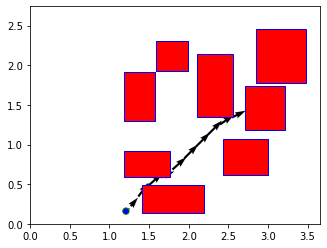

In [280]:
idx = np.random.randint(train_data[1].shape[0])

Xopt = optvals[0]

obstacles = []
for ii_obs in range(n_obs):
#     obs = train_data[0]['obstacles'][idx][:,ii_obs]
    obs = p_dict['obstacles'][:,ii_obs]
    obstacles.append(obs)

# x0 = train_data[0]['x0'][idx]
# x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
x0 = p_dict['x0']

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
    plt.gca().add_patch(circle)
    plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

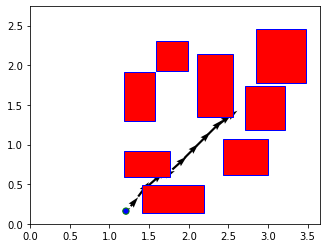

In [284]:
idx = np.random.randint(train_data[1].shape[0])

Xopt = optvals[0]

obstacles = []
for ii_obs in range(n_obs):
#     obs = train_data[0]['obstacles'][idx][:,ii_obs]
    obs = p_dict['obstacles'][:,ii_obs]
    obstacles.append(obs)

# x0 = train_data[0]['x0'][idx]
# x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
x0 = p_dict['x0']

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
    plt.gca().add_patch(circle)
    plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

In [ ]:
# shitty = True
# x0, obstacles = None, None
# while shitty:
#     obstacles = random_obs(n_obs, posmin, posmax, border_size, min_box_size, max_box_size)
#     x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
#     if all([x0[0] <= obstacle[0] and x0[0] <= obstacle[1] and \
#                  x0[1] <= obstacle[2] and x0[1] <= obstacle[3] for obstacle in obstacles]):
#         shitty = False
# obstacles = random_obs(n_obs, posmin, posmax, border_size, min_box_size, max_box_size)
# x0 = findIC(obstacles, posmin, posmax, velmin, velmax)

# if len(obstacles) is n_obs:
#     plt.axes()
#     for obstacle in obstacles:
#         rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
#                                   obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
#                                  fc='red', ec='blue')
#         plt.gca().add_patch(rectangle)
#         plt.axis('scaled')

#     circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
#     plt.gca().add_patch(circle)   

#     ax = plt.gca()
#     ax.margins(0)
#     ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
#     plt.show()

In [ ]:
# prob.init_bin_problem()

# p_dict = {}
# p_dict['x0'] = x0
# p_dict['obstacles'] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
# p_dict['xg'] = sample_dists['xg']()

# prob_success, cost, solve_time, optvals = prob.solve_micp(p_dict)
# prob_success

In [ ]:
# X = optvals[0]

# plt.axes()
# for obstacle in obstacles:
#     rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
#                               obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
#                              fc='red', ec='blue')
#     plt.gca().add_patch(rectangle)
#     plt.axis('scaled')

# for jj in range(N):
#     circle = plt.Circle((X[0,jj],X[1,jj]), 0.04, fc='blue',ec="blue")
#     plt.gca().add_patch(circle)   
    
# xg = p_dict['xg']
# circle = plt.Circle((xg[0],xg[1]), 0.04, fc='red',ec="red")
# plt.gca().add_patch(circle)   

# ax = plt.gca()
# ax.margins(0)
# ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
# plt.show()